In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo


In [3]:
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("../data/dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("../data/dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]

#### Lomb-Scargle periodogram.

Period in RV at max power is 122.0485 days


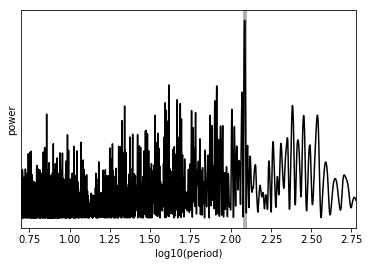

In [4]:
results = xo.estimators.lomb_scargle_estimator(
    alldates, allRV, max_peaks=1, min_period=5.0, max_period=600.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");
print('Period in RV at max power is {:.4f} days'.format(peak['period']))

Period in Halpha at max power is 86.9960 days


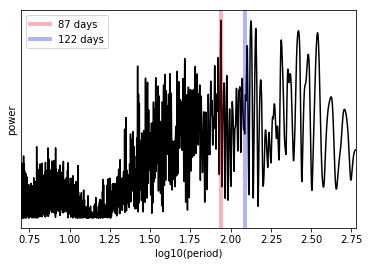

In [21]:
results = xo.estimators.lomb_scargle_estimator(
    alldates, allha, max_peaks=1, min_period=5.0, max_period=600.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="r", lw=4, alpha=0.3, label = '87 days')
plt.axvline(np.log10(122), color="b", lw=4, alpha=0.3, label='122 days')
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");
plt.legend()
print('Period in Halpha at max power is {:.4f} days'.format(peak['period']))

_class_ `pymc3.gp.cov.Periodic`(input_dim, period, ls=None, ls_inv=None, active_dims=None)

The Periodic kernel.
$$
k\left(x, x^{\prime}\right)=\exp \left(-\frac{2 \sin ^{2}\left(\pi\left|x-x^{\prime}\right| \frac{1}{T}\right)}{\ell^{2}}\right)
$$

_class_ `pymc3.gp.cov.ExpQuad`(input_dim, ls=None, ls_inv=None, active_dims=None)

`ls`: lengthscale parameter, it could be an array of length 2 for two demensional inputs.

The Exponentiated Quadratic kernel. Also refered to as the Squared Exponential, or Radial Basis Function kernel.
$$
k\left(x, x^{\prime}\right)=\exp \left[-\frac{\left(x-x^{\prime}\right)^{2}}{2 t^{2}}\right]
$$

Other form:
\begin{equation} \label{eq:quasi_kernel}
  k_{i,j} = A\ \mathrm{exp}\left[-\frac{(t_i - t_j)^2}{\lambda^2} - \frac{1}{2\omega^2}\mathrm{sin}^2\left(\frac{\pi(t_i -t_j)}{P}\right)\right] + \sigma_i^2\delta_{ij},%% <-- potentially cut the noise term of the equation
  \end{equation}

#### Try Normal priors:

In [5]:
with pm.Model() as model:
    logamp = pm.Normal('logamp',mu = np.log(8), sd = 10) 
    logperiod = pm.Normal('logperiod', mu = np.log(121),sd =10) 
    logls = pm.Normal('loglengthscale', mu = np.log(10), sd =15 )
    logpdecay = pm.Normal('logperdecay', mu = np.log(0.2), sd=15)
    
#     logamp=np.log(8)
#     logperiod = np.log(121)
#     logls = np.log(0.5)
#     logpdecay = np.log(0.02)

    cov_func= logamp * pm.gp.cov.Periodic(1, logperiod, logls) * pm.gp.cov.ExpQuad(1,logpdecay)
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    cov_noise = pm.Normal('noise', mu = np.std(allRVerr), sd = 0.5)
    y_ = gp.marginal_likelihood('y', X=alldates[:,None], y = allRV, noise = cov_noise)
    mp = pm.find_MAP(include_transformed=True)
    

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of 

In [6]:
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])



['logamp:5.999377898871226',
 'loglengthscale:3.052462952284981',
 'logperdecay:-8.318730447810886',
 'logperiod:3.231520502959506',
 'noise:0.9642314531561385']

In [7]:
with model:
    xnew = np.linspace(np.min(alldates), np.max(alldates),500)
    a = gp.predict(xnew[:,None],point=mp)

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futu

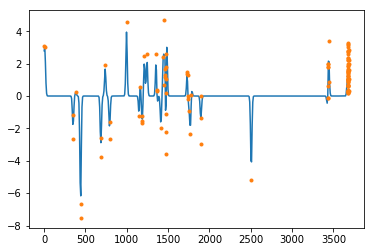

In [8]:
plt.plot(xnew, a[0])
plt.plot(alldates, allRV,'.')

In [9]:
with model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, logperdecay, loglengthscale, logperiod, logamp]
Sampling 4 chains: 100%|██████████| 12000/12000

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logamp,7.109857,2.421830,0.060665,3.242832,11.838446,1505.083551,1.001631
logperiod,7.366824,10.292739,0.653974,-14.093029,26.288947,116.265387,1.037033
loglengthscale,6.924433,13.756166,1.075400,-21.227947,34.648924,3.247398,1.670551
logperdecay,-14.202664,5.800303,0.154801,-24.885599,-4.750156,1285.998809,1.008192
noise,0.534641,0.911350,0.090764,-1.137360,1.240177,2.014303,12.441448


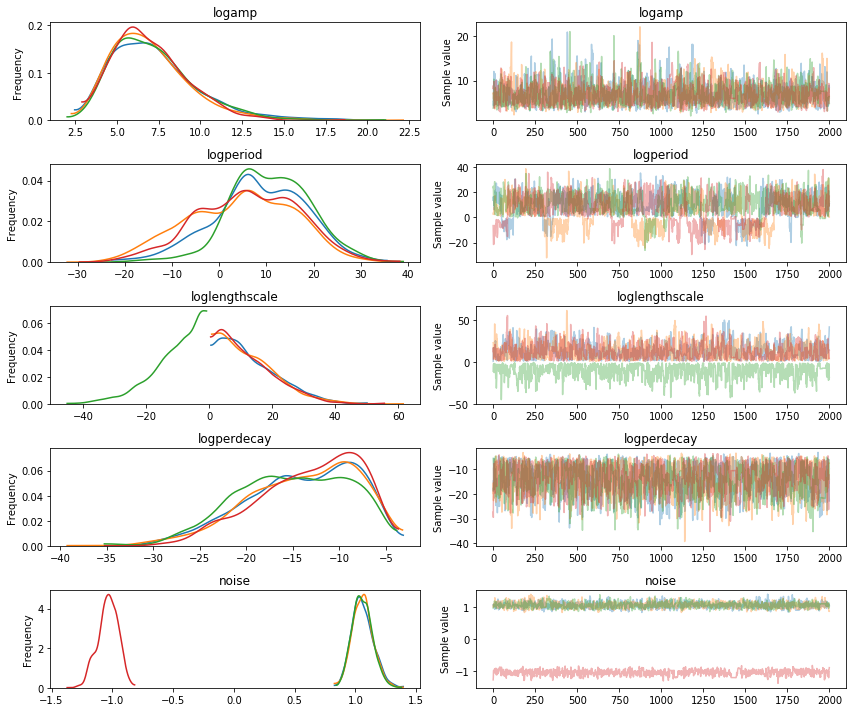

In [10]:
pm.traceplot(trace)
pm.summary(trace)

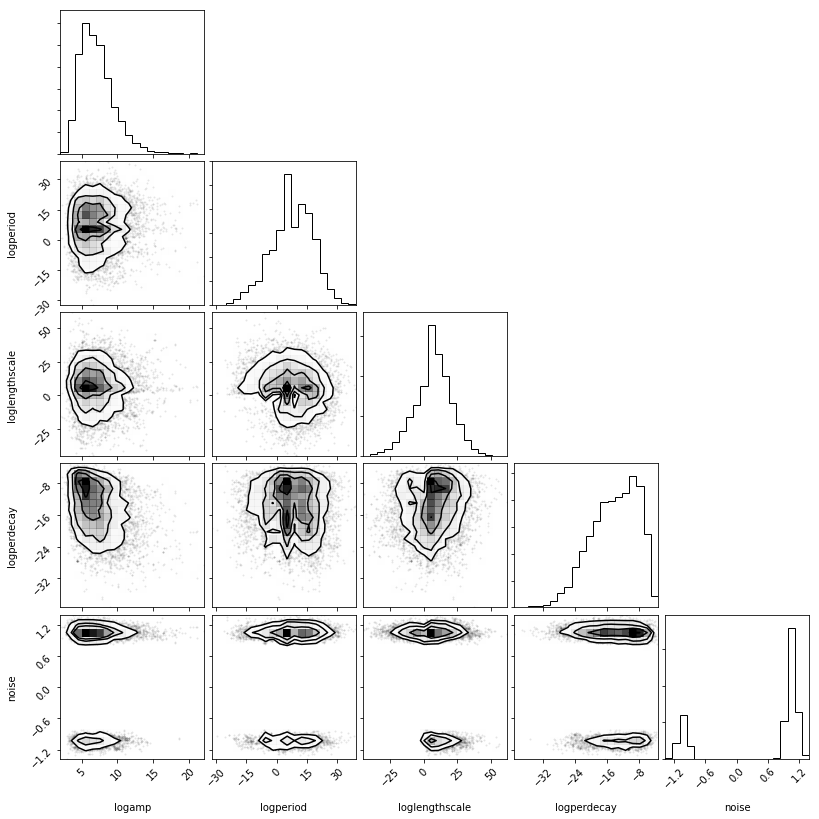

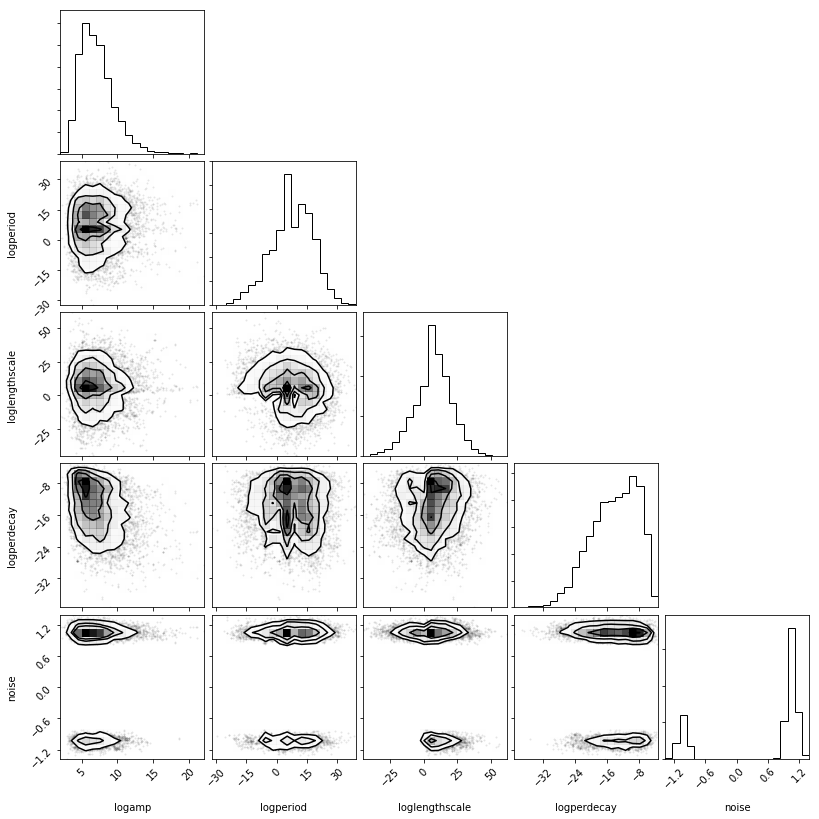

In [11]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples)

In [12]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

In [13]:
with model:
    f_pred= gp.conditional('fpred', xnew[:,None])
    
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred],samples=50)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


In [190]:
pred_samples['fpred'].shape

(50, 500)

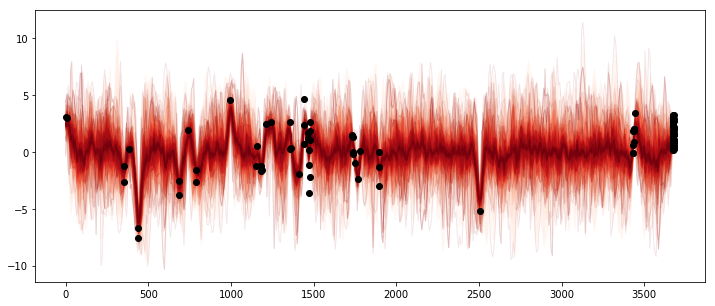

In [14]:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, pred_samples['fpred'][0:50], xnew[:,None])
plt.plot(alldates, allRV,'ok')

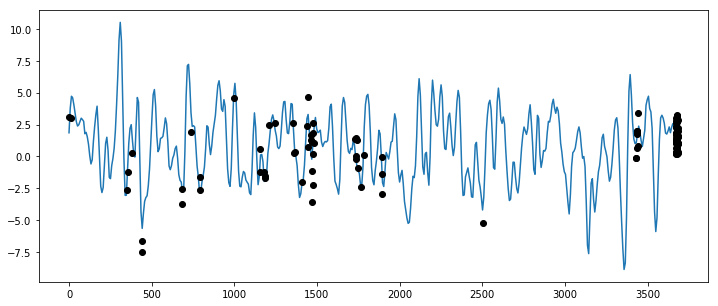

In [15]:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()
#plt.plot(xnew, pred_samples['fpred'][0])
#plt.plot(xnew, pred_samples['fpred'][1])
plt.plot(xnew, pred_samples['fpred'][2])
plt.plot(alldates, allRV,'ok')

In [16]:
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(allRVerr)), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(allRV)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(121.5), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, alldates, allRVerr**2 + tt.exp(logs2), J=4)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(allRV - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)


success: True
initial logp: -220.31632504592812
final logp: -207.68515416030402


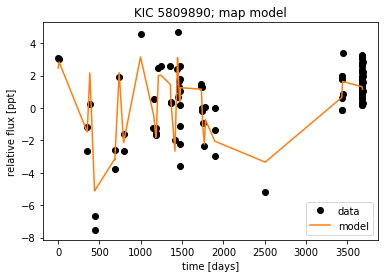

In [17]:
plt.plot(alldates, allRV, "ok", label="data")
plt.plot(alldates, map_soln["pred"], color="C1", label="model")

plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

In [18]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains: 100%|██████████| 808/808 [00:35<00:00,  6.72draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 4 chains: 100%|██████████| 8000/8000 [15:34<00:00,  1.51draws/s]
The acceptance probability does not match the target. It is 0.9623866658800724, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.960470529864628, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9668899918503383, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.529817,0.274899,0.008681,0.090167,0.999905,832.501956,1.000837
logdeltaQ,4.591344,8.958790,0.361142,-16.059539,21.390964,568.563929,1.000249
logQ0,-1.818118,4.314022,0.292150,-12.311437,4.730132,107.665844,1.025188
logperiod,5.360993,1.273855,0.084358,4.404783,8.076846,160.351489,1.011384
logamp,1.519096,0.668723,0.018031,0.245493,2.887018,1325.104613,1.001924
logs2,-0.945176,0.928386,0.064999,-1.627452,-0.030137,85.750395,1.017946
mean,0.093207,0.620833,0.021491,-1.116002,1.157857,690.248598,1.007641


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3a0fc390>,
      dtype=object)

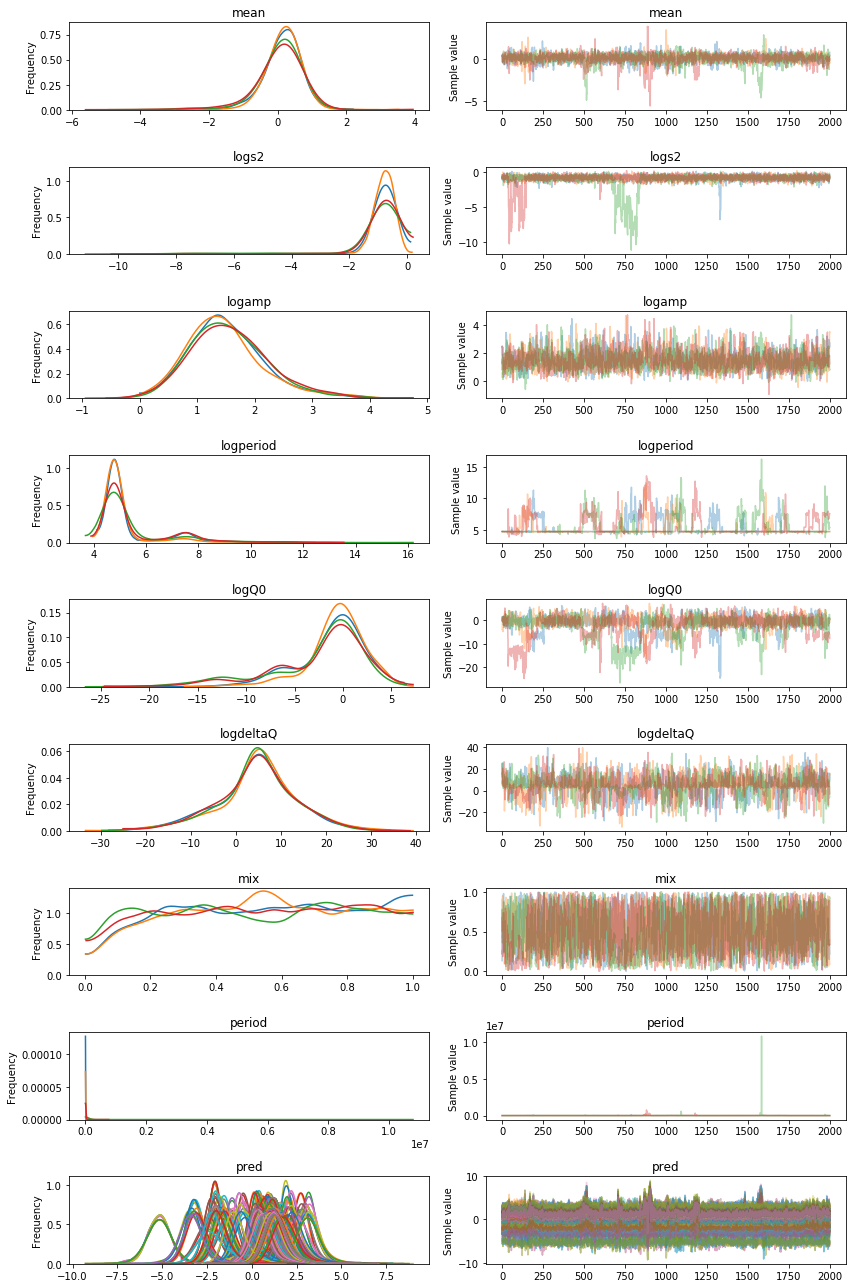

In [20]:
pm.traceplot(trace)

In [ ]:
samples = pm.trace_to_dataframe(trace)


KeyboardInterrupt: 

In [ ]:
# Generate 50 realizations of the prediction sampling randomly from the chain
N_pred = 50
pred_mu = np.empty((N_pred, len(xnew)))
pred_var = np.empty((N_pred, len(xnew)))
with model:
    pred = gp.predict(xnew, return_var=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=N_pred)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

# Plot the predictions
for i in range(len(pred_mu)):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    label = None if i else "prediction"
    art = plt.fill_between(true_t, mu+sd, mu-sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    plt.plot(xnew, mu, color="C1", label=label, alpha=0.1)

plt.errorbar(alldates, allRV, yerr=allRVerr, fmt=".k", capsize=0, label="data")
plt.legend(fontsize=12)
plt.xlabel("Dates")
plt.ylabel("RV")
#plt.xlim(0, 10)
#plt.ylim(-2.5, 2.5);